### Importación de datos



In [15]:
import pandas as pd

datos_tienda = [
"https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv",
"https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv",
"https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv",
"https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv",
]

class Tienda:

  def __init__(self, alias: str, data: str) -> None:
    self.nombre = alias
    self.df_reader = pd.read_csv(data)

  def get_values(self, col: str) -> list:
    return self.df_reader[col].to_list()

  def ventas(self) -> float:
    return round(self.df_reader["Precio"].sum(), 2)

  def categorías(self) -> dict:
    # when using gruopby the values in the col become the labels for
    # the row position in the new grouped table, with agg you can create custom
    # rows with aliases and defined values similar to the aggragate method
    # in django
    name_alias = f"total de ventas por categoría"
    # to_dict by default return values like {col: {index: value}}
    return self.df_reader.groupby("Categoría del Producto").agg(**{name_alias: ("Producto", "count")}).sort_values(by=name_alias, ascending=False).to_dict()

  def valoración_promedio(self) -> float:
    return round(self.df_reader["Calificación"].mean(), 2)

  def costo_envio_promedio(self) -> float:
    return round(self.df_reader["Costo de envío"].mean(), 2)

  def más_y_menos_vendido(self) -> dict:
    name_alias = f"producto más vendido en {self.nombre}"
    grouped = self.df_reader.groupby("Producto").agg(**{name_alias: ("Precio", "count")})
    más = grouped[name_alias].idxmax()
    menos = grouped[name_alias].idxmin()
    return {"más": {"producto": más, "cantidad": grouped.loc[más, name_alias]},
            "menos": {"producto": menos, "cantidad": grouped.loc[menos, name_alias]},
            }

  def sumario(self) -> dict:
    cantidad = self.más_y_menos_vendido()
    return {"tienda": self.nombre, "ventas": self.ventas(),
            "categorías y sus ventas": self.categorías(),
            "valoración promedio": self.valoración_promedio(),
            "costo envio promedio": self.costo_envio_promedio(),
            "item más vendido": cantidad["más"],
            "item menos vendido": cantidad["menos"]}

names = [f"tienda {i}" for i in range(1,5)]
resultados = []
for nombre, datos in zip(names, datos_tienda):
  resultados.append(Tienda(nombre, datos))



#1. Análisis de facturación



In [16]:
# cantidades vendidas por cada tienda
for tienda_ob in resultados:
  print(tienda_ob.nombre, tienda_ob.ventas())



tienda 1 1150880400.0
tienda 2 1116343500.0
tienda 3 1098019600.0
tienda 4 1038375700.0


# 2. Ventas por categoría

In [17]:
for tienda_ob in resultados:
  print(tienda_ob.categorías())

{'total de ventas por categoría': {'Muebles': 465, 'Electrónicos': 448, 'Juguetes': 324, 'Electrodomésticos': 312, 'Deportes y diversión': 284, 'Instrumentos musicales': 182, 'Libros': 173, 'Artículos para el hogar': 171}}
{'total de ventas por categoría': {'Muebles': 442, 'Electrónicos': 422, 'Juguetes': 313, 'Electrodomésticos': 305, 'Deportes y diversión': 275, 'Instrumentos musicales': 224, 'Libros': 197, 'Artículos para el hogar': 181}}
{'total de ventas por categoría': {'Muebles': 499, 'Electrónicos': 451, 'Juguetes': 315, 'Electrodomésticos': 278, 'Deportes y diversión': 277, 'Libros': 185, 'Artículos para el hogar': 177, 'Instrumentos musicales': 177}}
{'total de ventas por categoría': {'Muebles': 480, 'Electrónicos': 451, 'Juguetes': 338, 'Deportes y diversión': 277, 'Electrodomésticos': 254, 'Artículos para el hogar': 201, 'Libros': 187, 'Instrumentos musicales': 170}}


# 3. Calificación promedio de la tienda


In [18]:
for tienda_ob in resultados:
  print(tienda_ob.nombre, tienda_ob.valoración_promedio())

tienda 1 3.98
tienda 2 4.04
tienda 3 4.05
tienda 4 4.0


# 4. Productos más y menos vendidos

In [19]:
for tienda_ob in resultados:
  print(tienda_ob.nombre, tienda_ob.más_y_menos_vendido())

tienda 1 {'más': {'producto': 'Armario', 'cantidad': np.int64(60)}, 'menos': {'producto': 'Auriculares con micrófono', 'cantidad': np.int64(33)}}
tienda 2 {'más': {'producto': 'Iniciando en programación', 'cantidad': np.int64(65)}, 'menos': {'producto': 'Juego de mesa', 'cantidad': np.int64(32)}}
tienda 3 {'más': {'producto': 'Kit de bancas', 'cantidad': np.int64(57)}, 'menos': {'producto': 'Bloques de construcción', 'cantidad': np.int64(35)}}
tienda 4 {'más': {'producto': 'Cama box', 'cantidad': np.int64(62)}, 'menos': {'producto': 'Guitarra eléctrica', 'cantidad': np.int64(33)}}


# 5. Envío promedio por tienda

In [20]:
for tienda_ob in resultados:
  print(tienda_ob.nombre, tienda_ob.costo_envio_promedio())

tienda 1 26018.61
tienda 2 25216.24
tienda 3 24805.68
tienda 4 23459.46


{'tienda': 'tienda 1', 'ventas': np.float64(1150880400.0), 'categorías y sus ventas': {'total de ventas por categoría': {'Muebles': 465, 'Electrónicos': 448, 'Juguetes': 324, 'Electrodomésticos': 312, 'Deportes y diversión': 284, 'Instrumentos musicales': 182, 'Libros': 173, 'Artículos para el hogar': 171}}, 'valoración promedio': np.float64(3.98), 'costo envio promedio': np.float64(26018.61), 'item más vendido': {'producto': 'Armario', 'cantidad': np.int64(60)}, 'item menos vendido': {'producto': 'Auriculares con micrófono', 'cantidad': np.int64(33)}}
{'tienda': 'tienda 2', 'ventas': np.float64(1116343500.0), 'categorías y sus ventas': {'total de ventas por categoría': {'Muebles': 442, 'Electrónicos': 422, 'Juguetes': 313, 'Electrodomésticos': 305, 'Deportes y diversión': 275, 'Instrumentos musicales': 224, 'Libros': 197, 'Artículos para el hogar': 181}}, 'valoración promedio': np.float64(4.04), 'costo envio promedio': np.float64(25216.24), 'item más vendido': {'producto': 'Iniciando 

# 6. Graficos

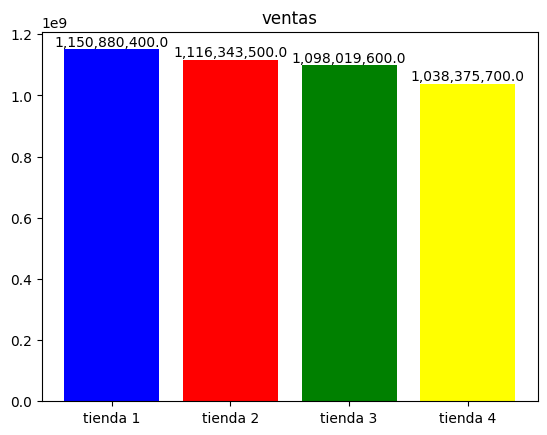

In [38]:
import matplotlib.pyplot as plt
# ventas
ventas = [float(item.ventas()) for item in resultados]
nombres = [item.nombre for item in resultados]
colores = ["blue", "red", "green", "yellow"]
plt.bar(nombres, ventas, color=colores)
plt.yscale("linear")
for count, item in enumerate(ventas):
  plt.text(count, item, f"{item:,}", ha='center', va='bottom')
plt.title("ventas")
plt.show()